In [1]:
import re
import string
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, classification_report
from sklearn.model_selection import (train_test_split,StratifiedKFold,GridSearchCV)
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
from sklearn.metrics import log_loss, matthews_corrcoef, roc_auc_score
from itertools import product
import textstat
from sklearn.feature_selection import RFE
import joblib
from sklearn.metrics import confusion_matrix, f1_score, precision_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score, log_loss, matthews_corrcoef
import pandas as pd
import joblib
from sklearn.naive_bayes import MultinomialNB

In [2]:
df_train = pd.read_csv("phishing_email.csv",sep=",")
df_train

,text_combined,label
0,hpl nom may 25 2001 see attached file hplno 52...,0
1,nom actual vols 24 th forwarded sabrae zajac h...,0
2,enron actuals march 30 april 1 201 estimated a...,0
3,hpl nom may 30 2001 see attached file hplno 53...,0
4,hpl nom june 1 2001 see attached file hplno 60...,0
...,...,...
82481,info advantageapartmentscom infoadvantageapart...,1
82482,monkeyorg helpdeskmonkeyorg monkeyorg hi josep...,1
82483,help center infohelpcentercoza_infohelpcenterc...,1
82484,metamask infosofamekarcom verify metamask wall...,1


In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82486 entries, 0 to 82485
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text_combined  82486 non-null  object
 1   label          82486 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.3+ MB


In [4]:
df_train.rename(columns={"label":"Classe","text_combined":"Email"},inplace=True)

In [5]:
df_train

,Email,Classe
0,hpl nom may 25 2001 see attached file hplno 52...,0
1,nom actual vols 24 th forwarded sabrae zajac h...,0
2,enron actuals march 30 april 1 201 estimated a...,0
3,hpl nom may 30 2001 see attached file hplno 53...,0
4,hpl nom june 1 2001 see attached file hplno 60...,0
...,...,...
82481,info advantageapartmentscom infoadvantageapart...,1
82482,monkeyorg helpdeskmonkeyorg monkeyorg hi josep...,1
82483,help center infohelpcentercoza_infohelpcenterc...,1
82484,metamask infosofamekarcom verify metamask wall...,1


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82486 entries, 0 to 82485
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Email   82486 non-null  object
 1   Classe  82486 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.3+ MB


In [7]:
df_train.isnull().sum()

Email     0
Classe    0
dtype: int64

In [8]:
df_train.duplicated().sum()

408

In [9]:
df_train.drop_duplicates(subset = ['Email'], inplace = True)

In [10]:
df_train.head()

,Email,Classe
0,hpl nom may 25 2001 see attached file hplno 52...,0
1,nom actual vols 24 th forwarded sabrae zajac h...,0
2,enron actuals march 30 april 1 201 estimated a...,0
3,hpl nom may 30 2001 see attached file hplno 53...,0
4,hpl nom june 1 2001 see attached file hplno 60...,0


Classe
0    39233
1    42845
Name: count, dtype: int64


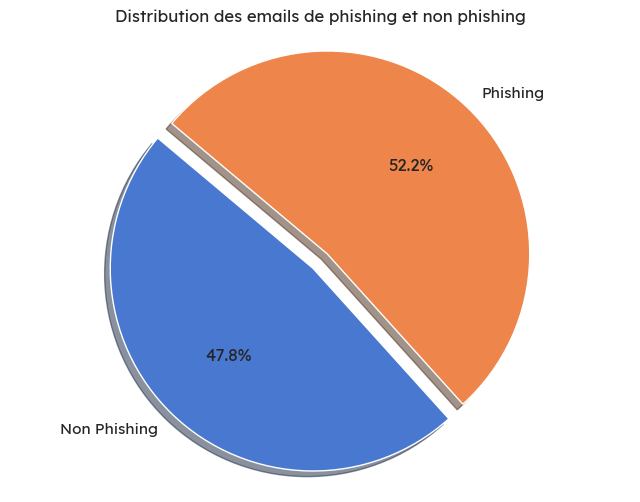

In [11]:
print(df_train['Classe'].value_counts().sort_index())
sns.set_theme(font="Lexend",style="whitegrid", palette="muted")
explode = (0, 0.1)
plt.figure(figsize=(8, 6))
plt.pie(df_train['Classe'].value_counts().sort_index(),labels=["Non Phishing", "Phishing"],explode=explode,autopct='%1.1f%%',startangle=140,shadow=True,)
plt.title('Distribution des emails de phishing et non phishing')
plt.axis('equal')
plt.show()

In [12]:
nltk.download('punkt_tab')
df_train['Longueur'] = df_train['Email'].apply(len)
df_train = df_train[df_train['Longueur'] != 0]
df_train['nombre_mots'] = df_train['Email'].apply(lambda x: len(x.split()))
df_train['flesch_kincaid'] = df_train['Email'].apply(lambda x: textstat.flesch_kincaid_grade(x))
df_train['nombre_caracteres_speciaux'] = df_train['Email'].apply(lambda x: len(re.findall(r'[^a-zA-Z0-9\s]', x)))

df_train

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\safwe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


,Email,Classe,Longueur,nombre_mots,flesch_kincaid,nombre_caracteres_speciaux
0,hpl nom may 25 2001 see attached file hplno 52...,0,65,14,2.9,0
1,nom actual vols 24 th forwarded sabrae zajac h...,0,1071,208,82.1,0
2,enron actuals march 30 april 1 201 estimated a...,0,148,28,11.8,0
3,hpl nom may 30 2001 see attached file hplno 53...,0,65,14,2.9,0
4,hpl nom june 1 2001 see attached file hplno 60...,0,65,14,2.9,0
...,...,...,...,...,...,...
82481,info advantageapartmentscom infoadvantageapart...,1,1735,238,96.1,34
82482,monkeyorg helpdeskmonkeyorg monkeyorg hi josep...,1,188,22,19.0,0
82483,help center infohelpcentercoza_infohelpcenterc...,1,948,108,53.7,2
82484,metamask infosofamekarcom verify metamask wall...,1,376,50,28.7,0


C:\Users\safwe\AppData\Local\Temp\ipykernel_11552\2204090053.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_train, x='flesch_kincaid', y='Classe', orient='h', ci=None, palette={'0': 'green', '1': 'red'})
C:\Users\safwe\AppData\Local\Temp\ipykernel_11552\2204090053.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_train, x='flesch_kincaid', y='Classe', orient='h', ci=None, palette={'0': 'green', '1': 'red'})


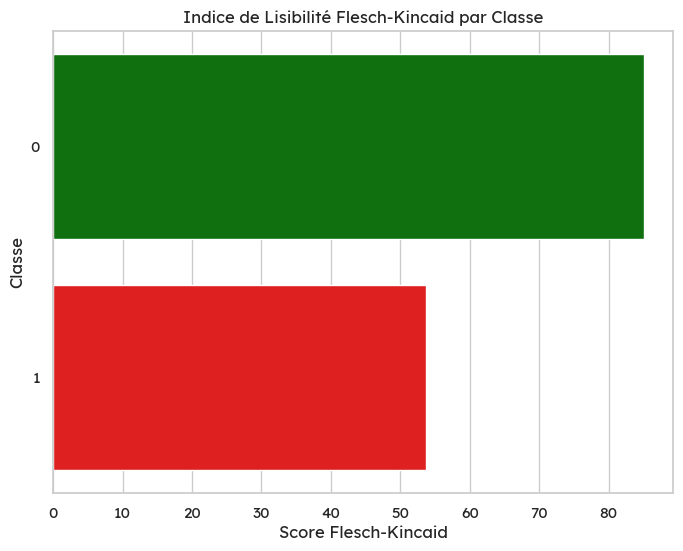

In [13]:
plt.figure(figsize=(8, 6))
sns.barplot(data=df_train, x='flesch_kincaid', y='Classe', orient='h', ci=None, palette={'0': 'green', '1': 'red'})
plt.title('Indice de Lisibilité Flesch-Kincaid par Classe')
plt.xlabel('Score Flesch-Kincaid')
plt.ylabel('Classe')
plt.show()

C:\Users\safwe\AppData\Local\Temp\ipykernel_11552\884015555.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_train, x='nombre_caracteres_speciaux', y='Classe', orient='h', ci=None, palette={'0': 'green', '1': 'red'})
C:\Users\safwe\AppData\Local\Temp\ipykernel_11552\884015555.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_train, x='nombre_caracteres_speciaux', y='Classe', orient='h', ci=None, palette={'0': 'green', '1': 'red'})


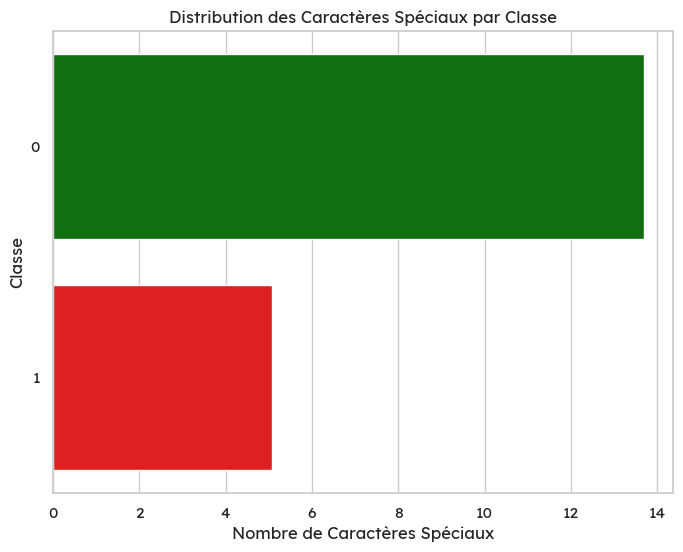

In [14]:
plt.figure(figsize=(8, 6))
sns.barplot(data=df_train, x='nombre_caracteres_speciaux', y='Classe', orient='h', ci=None, palette={'0': 'green', '1': 'red'})
plt.title('Distribution des Caractères Spéciaux par Classe')
plt.xlabel('Nombre de Caractères Spéciaux')
plt.ylabel('Classe')
plt.show()

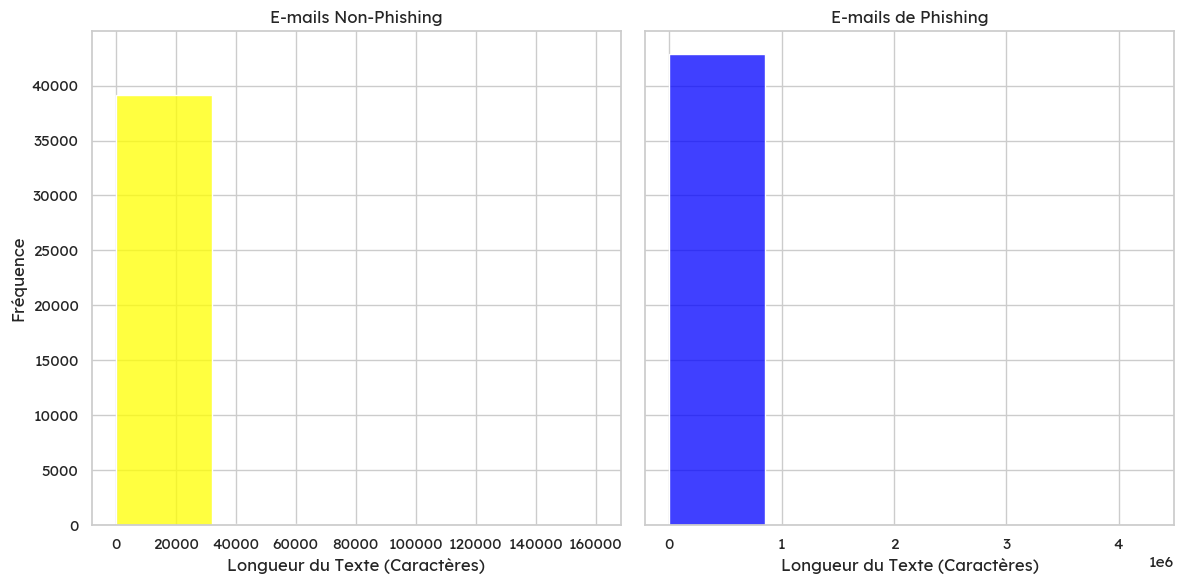

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

sns.histplot(df_train[df_train['Classe'] == 0]['Longueur'], bins=5, kde=False, ax=axes[0], color='yellow')
axes[0].set_title("E-mails Non-Phishing")
axes[0].set_xlabel("Longueur du Texte (Caractères)")
axes[0].set_ylabel("Fréquence")

sns.histplot(df_train[df_train['Classe'] == 1]['Longueur'], bins=5, kde=False, ax=axes[1], color='blue')
axes[1].set_title("E-mails de Phishing")
axes[1].set_xlabel("Longueur du Texte (Caractères)")

plt.tight_layout()
plt.show()

In [16]:
moyenne_longueur_phishing = df_train[df_train['Classe'] == 1]['Longueur'].mean()

moyenne_longueur_ham = df_train[df_train['Classe'] == 0]['Longueur'].mean()

print("Longueur moyenne des emails de phishing :", moyenne_longueur_phishing)

print("Longueur moyenne des emails légitimes :", moyenne_longueur_ham)

Longueur moyenne des emails de phishing : 1060.692519547205
Longueur moyenne des emails légitimes : 1541.4561466112712


C:\Users\safwe\AppData\Local\Temp\ipykernel_11552\190470243.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Phishing', 'Ham'], y=[moyenne_longueur_phishing, moyenne_longueur_ham], palette='viridis')


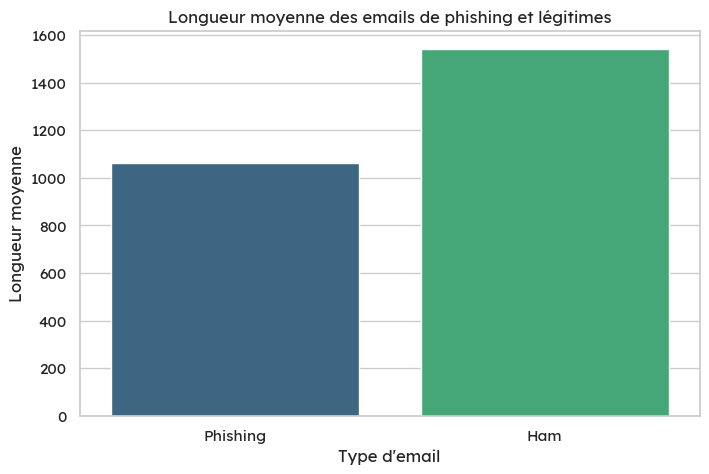

In [17]:
plt.figure(figsize=(8, 5))
sns.barplot(x=['Phishing', 'Ham'], y=[moyenne_longueur_phishing, moyenne_longueur_ham], palette='viridis')
plt.title('Longueur moyenne des emails de phishing et légitimes')
plt.xlabel('Type d\'email')
plt.ylabel('Longueur moyenne')
plt.show()

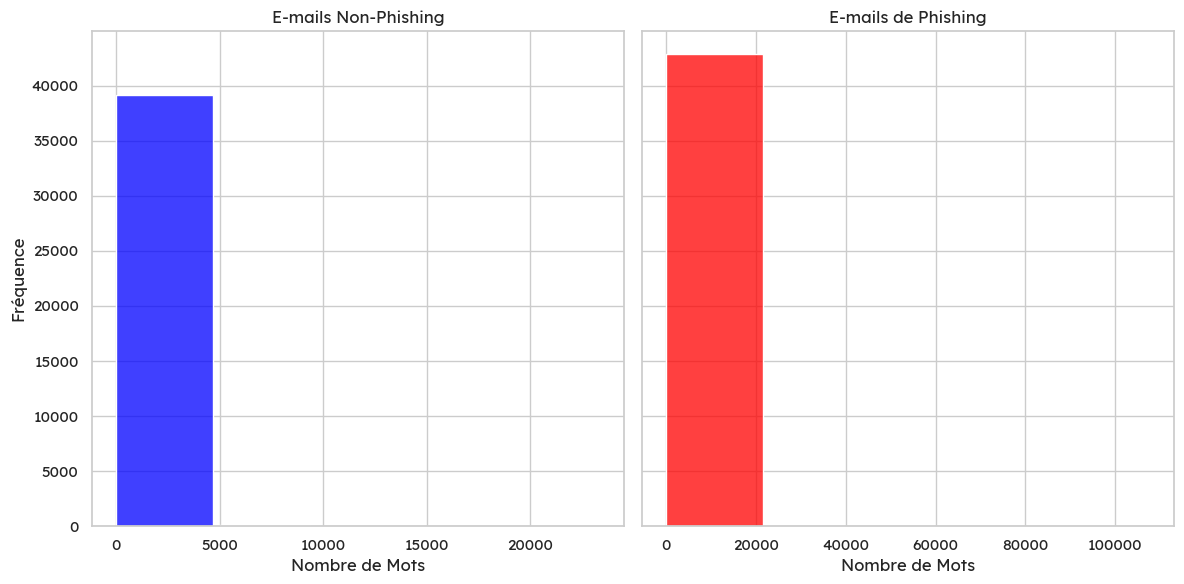

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

sns.histplot(df_train[df_train['Classe'] == 0]['nombre_mots'], bins=5, kde=False, ax=axes[0], color='blue')
axes[0].set_title("E-mails Non-Phishing")
axes[0].set_xlabel("Nombre de Mots")
axes[0].set_ylabel("Fréquence")

sns.histplot(df_train[df_train['Classe'] == 1]['nombre_mots'], bins=5, kde=False, ax=axes[1], color='red')
axes[1].set_title("E-mails de Phishing")
axes[1].set_xlabel("Nombre de Mots")

plt.tight_layout()
plt.show()

In [19]:
moyenne_mots_phishing = df_train[df_train['Classe'] == 1]['nombre_mots'].mean()

moyenne_mots_ham = df_train[df_train['Classe'] == 0]['nombre_mots'].mean()

print("moyenne_mots_ham : ", moyenne_mots_ham)
print("moyenne_mots_phishing : ", moyenne_mots_phishing)


moyenne_mots_ham :  203.70389722937324
moyenne_mots_phishing :  121.35023923444976


C:\Users\safwe\AppData\Local\Temp\ipykernel_11552\4288300181.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Phishing', 'Ham'], y=[moyenne_mots_phishing, moyenne_mots_ham], palette='coolwarm')


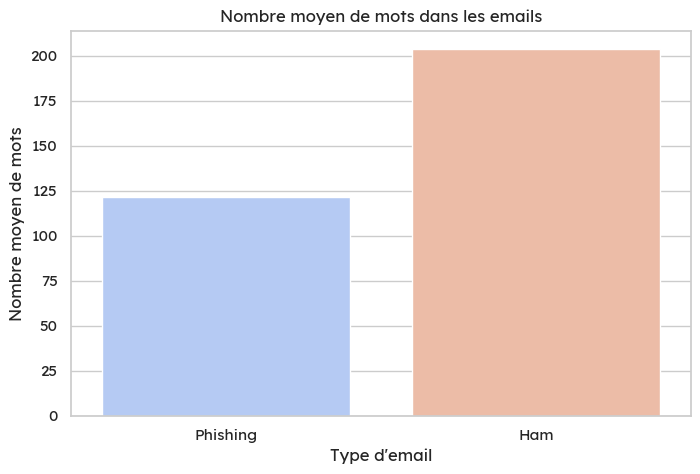

In [20]:
plt.figure(figsize=(8, 5))
sns.barplot(x=['Phishing', 'Ham'], y=[moyenne_mots_phishing, moyenne_mots_ham], palette='coolwarm')
plt.title('Nombre moyen de mots dans les emails')
plt.xlabel('Type d\'email')
plt.ylabel('Nombre moyen de mots')
plt.show()

In [21]:
df_train

,Email,Classe,Longueur,nombre_mots,flesch_kincaid,nombre_caracteres_speciaux
0,hpl nom may 25 2001 see attached file hplno 52...,0,65,14,2.9,0
1,nom actual vols 24 th forwarded sabrae zajac h...,0,1071,208,82.1,0
2,enron actuals march 30 april 1 201 estimated a...,0,148,28,11.8,0
3,hpl nom may 30 2001 see attached file hplno 53...,0,65,14,2.9,0
4,hpl nom june 1 2001 see attached file hplno 60...,0,65,14,2.9,0
...,...,...,...,...,...,...
82481,info advantageapartmentscom infoadvantageapart...,1,1735,238,96.1,34
82482,monkeyorg helpdeskmonkeyorg monkeyorg hi josep...,1,188,22,19.0,0
82483,help center infohelpcentercoza_infohelpcenterc...,1,948,108,53.7,2
82484,metamask infosofamekarcom verify metamask wall...,1,376,50,28.7,0


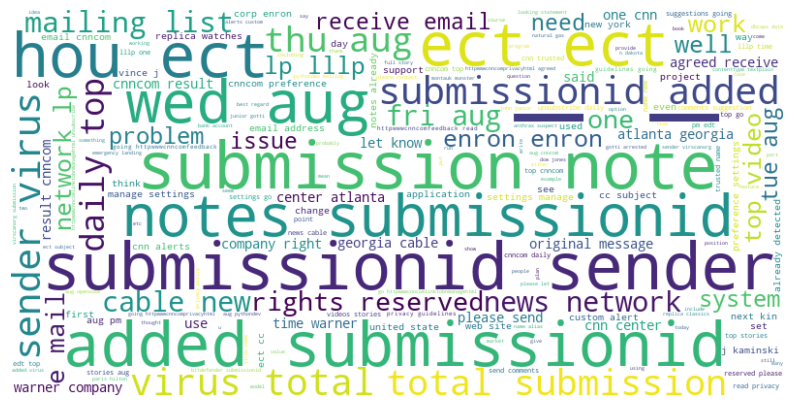

In [22]:
text = ' '.join(df_train['Email'].dropna())
stopwords1 = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords1, background_color='white', max_words=200, width=800, height=400).generate(text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [23]:
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

df_train['Sentiment'] = df_train['Email'][df_train["Classe"] == 1].apply(lambda x: get_sentiment(str(x)))

print(df_train[['Email', 'Sentiment']].head())


df_train['Sentiment_Classe'] = df_train['Sentiment'].apply(lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutre'))


print(df_train['Sentiment_Classe'].value_counts())

df_train.drop(columns=['Sentiment'],inplace=True)
df_train = pd.get_dummies(df_train, columns=['Sentiment_Classe'], prefix='Sentiment')

                                               Email  Sentiment
0  hpl nom may 25 2001 see attached file hplno 52...        NaN
1  nom actual vols 24 th forwarded sabrae zajac h...        NaN
2  enron actuals march 30 april 1 201 estimated a...        NaN
3  hpl nom may 30 2001 see attached file hplno 53...        NaN
4  hpl nom june 1 2001 see attached file hplno 60...        NaN
Sentiment_Classe
Neutre      43640
Positive    35206
Negative     3232
Name: count, dtype: int64


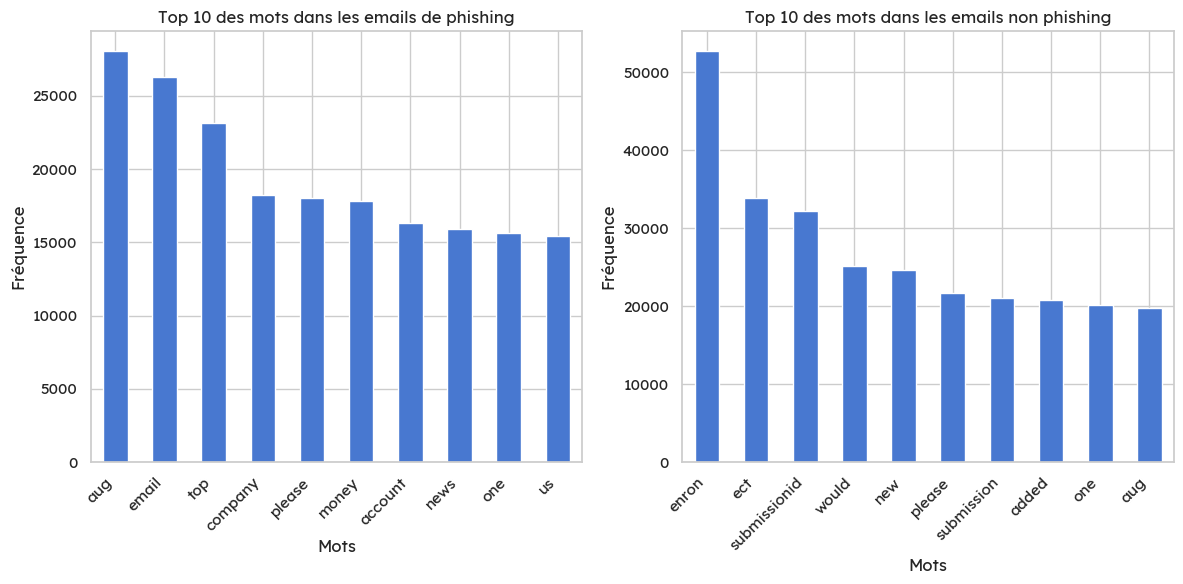

In [24]:
def obtenir_mots_frequents(emails):
    texte = ' '.join(emails)
    
    mots = word_tokenize(texte.lower())
    mots_vides = set(stopwords.words('english')) 
    mots = [mot for mot in mots if mot.isalpha() and mot not in mots_vides]
    
    frequence_mots = pd.Series(mots).value_counts()
    
    return frequence_mots.head(10)


mots_phishing = obtenir_mots_frequents(df_train[df_train['Classe'] == 1]['Email'])
mots_non_phishing = obtenir_mots_frequents(df_train[df_train['Classe'] == 0]['Email'])

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
mots_phishing.plot(kind='bar')
plt.title('Top 10 des mots dans les emails de phishing')
plt.xlabel('Mots')
plt.ylabel('Fréquence')
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 2, 2)
mots_non_phishing.plot(kind='bar')
plt.title('Top 10 des mots dans les emails non phishing')
plt.xlabel('Mots')
plt.ylabel('Fréquence')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [25]:
def trouver_emails_extremes(df):
    emails_phishing = df[df['Classe'] == 1]
    emails_non_phishing = df[df['Classe'] == 0]
    
    plus_long_phishing = emails_phishing.loc[emails_phishing['Longueur'].idxmax()]
    plus_court_phishing = emails_phishing.loc[emails_phishing['Longueur'].idxmin()]
        
    plus_long_non_phishing = emails_non_phishing.loc[emails_non_phishing['Longueur'].idxmax()]
    plus_court_non_phishing = emails_non_phishing.loc[emails_non_phishing['Longueur'].idxmin()]
    
    print("Emails de Phishing:")
    print("Email le plus long:")
    print(f"Longueur : {plus_long_phishing['Longueur']}")
    print(f"Texte : {plus_long_phishing['Email'][:500]}...\n")
    
    print("Email le plus court:")
    print(f"Longueur : {plus_court_phishing['Longueur']}")
    print(f"Texte : {plus_court_phishing['Email']}\n")
    
    print("Emails Non Phishing:")
    print("Email le plus long:")
    print(f"Longueur : {plus_long_non_phishing['Longueur']}")
    print(f"Texte : {plus_long_non_phishing['Email'][:500]}...\n")
    
    print("Email le plus court:")
    print(f"Longueur : {plus_court_non_phishing['Longueur']}")
    print(f"Texte : {plus_court_non_phishing['Email']}")


trouver_emails_extremes(df_train)

Emails de Phishing:
Email le plus long:
Longueur : 4279526
Texte : mail system internal data mailerdaemonmonkeyorg text part internal format mail folder real message created automatically mail system software deleted important folder data lost recreated data reset initial values 125117ihposblngweb5ihpiinetnetau fri jan 2 071900 2015 returnpath 125117ihposblngweb5ihpiinetnetau xoriginalto joseloginmonkeyorg deliveredto joseloginmonkeyorg received forwardbhostedemailcom forwardbhostedemailcom 64983617 lmonkeyorg postfix esmtp id 180e6f4007 fri 2 jan 2015 071900 0...

Email le plus court:
Longueur : 1
Texte :  

Emails Non Phishing:
Email le plus long:
Longueur : 160318
Texte : enron mentions enron wake call wall street journal 12 04 01 fall power giant dynegy hits back enron lawsuit claim failed merger entitles concern get northern natural gas wall street journal 12 04 01 enron secures 1 5 billion new financing j p morgan citigroup pact first step lifeline sought trading unit wall street

In [26]:
df_train

,Email,Classe,Longueur,nombre_mots,flesch_kincaid,nombre_caracteres_speciaux,Sentiment_Negative,Sentiment_Neutre,Sentiment_Positive
0,hpl nom may 25 2001 see attached file hplno 52...,0,65,14,2.9,0,False,True,False
1,nom actual vols 24 th forwarded sabrae zajac h...,0,1071,208,82.1,0,False,True,False
2,enron actuals march 30 april 1 201 estimated a...,0,148,28,11.8,0,False,True,False
3,hpl nom may 30 2001 see attached file hplno 53...,0,65,14,2.9,0,False,True,False
4,hpl nom june 1 2001 see attached file hplno 60...,0,65,14,2.9,0,False,True,False
...,...,...,...,...,...,...,...,...,...
82481,info advantageapartmentscom infoadvantageapart...,1,1735,238,96.1,34,False,False,True
82482,monkeyorg helpdeskmonkeyorg monkeyorg hi josep...,1,188,22,19.0,0,False,True,False
82483,help center infohelpcentercoza_infohelpcenterc...,1,948,108,53.7,2,True,False,False
82484,metamask infosofamekarcom verify metamask wall...,1,376,50,28.7,0,False,False,True


In [27]:
phishing_emails = df_train[df_train["Classe"] == 1]
non_phishing_emails = df_train[df_train["Classe"] == 0]

In [28]:
phishing_sample = phishing_emails.sample(n=5000, random_state=42)
non_phishing_sample = non_phishing_emails.sample(n=5000, random_state=42)
df_sample = pd.concat([phishing_sample, non_phishing_sample]).reset_index(drop=True)
df_train = df_sample.sample(frac=1, random_state=42).reset_index(drop=True)

In [29]:
def pretraitement_text(text, unwanted_terms):
    text = text.lower()
    text = re.sub(r'\b\d+\b', '', text) 
    text = re.sub(r'\b(?:mon|tue|wed|thu|fri|sat|sun)\b', '', text, flags=re.IGNORECASE) 
    text = re.sub(r'\b(?:jan|feb|mar|apr|may|jun|jul|aug|sep|oct|nov|dec)\b', '', text, flags=re.IGNORECASE)  
    for term in unwanted_terms:
        text = re.sub(rf'\b{term}\b', '', text, flags=re.IGNORECASE)
    text = re.sub(r'[^\w\s]', '', text)  
    text = re.sub(r'\s+', ' ', text).strip()  

    return text

In [30]:
termes_non_souhaite = ['enron', 'hpl', 'nom', 'forwarded'] 
df_train['Email'] = df_train['Email'].apply(lambda x: pretraitement_text(x, termes_non_souhaite))

In [31]:
X = df_train["Email"]
y = df_train["Classe"]

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,stratify=y)

In [33]:
modeles ={}

In [34]:
parametres_tfidf = {
    'max_caracteristiques': [1000, 3000, 5000, 10000],
    'max_df': [0.7, 0.85, 1.0],
    'min_df': [1, 2, 5],
    'plage_ngrammes': [(1, 1), (1, 2)]
}


parametres_rf = {
    'n_estimateurs': [50, 100, 200],
    'profondeur_max': [None, 10, 20]
}


combinaisons_tfidf = list(product(
    parametres_tfidf['max_caracteristiques'],
    parametres_tfidf['max_df'],
    parametres_tfidf['min_df'],
    parametres_tfidf['plage_ngrammes']
))


combinaisons_rf = list(product(
    parametres_rf['n_estimateurs'],
    parametres_rf['profondeur_max']
))

resultats = []
total_iterations = len(combinaisons_tfidf) * len(combinaisons_rf)
compteur_iteration = 0

def preparer_tfidf(X_entrainement, X_test, max_caracteristiques, max_df, min_df, plage_ngrammes):

    tfidf = TfidfVectorizer(
        max_features=max_caracteristiques,
        max_df=max_df,
        min_df=min_df,
        ngram_range=plage_ngrammes,
        stop_words='english'
    )
    
    X_entrainement_tfidf = tfidf.fit_transform(X_entrainement)
    X_test_tfidf = tfidf.transform(X_test)
    
    return X_entrainement_tfidf, X_test_tfidf

def entrainer_modele_rf(X_entrainement_tfidf, y_entrainement, n_estimateurs, profondeur_max):

    modele_rf = RandomForestClassifier(
        n_estimators=n_estimateurs,
        max_depth=profondeur_max,
        random_state=42
    )
    
    modele_rf.fit(X_entrainement_tfidf, y_entrainement)
    return modele_rf

def calculer_metriques_rf(modele_rf, X_test_tfidf, y_test):

    y_pred_rf = modele_rf.predict(X_test_tfidf)
    y_pred_proba_rf = modele_rf.predict_proba(X_test_tfidf)[:, 1]
    
    metriques = {
        'accuracy': accuracy_score(y_test, y_pred_rf),
        'auc': roc_auc_score(y_test, y_pred_proba_rf),
        'logloss': log_loss(y_test, y_pred_proba_rf),
        'mcc': matthews_corrcoef(y_test, y_pred_rf),
        'y_pred_rf': y_pred_rf,
        'y_pred_proba_rf': y_pred_proba_rf
    }
    
    return metriques

import time

def sauvegarder_resultats_et_journal(compteur_iteration, total_iterations, temps_debut, metriques, parametres, resultats):

    temps_fin = time.time()
    

    resultats.append({
        **parametres,
        'accuracy': metriques['accuracy'],
        'auc': metriques['auc'],
        'logloss': metriques['logloss'],
        'mcc': metriques['mcc']
    })
    

    print(f"Exécution {compteur_iteration}/{total_iterations} terminée en {temps_fin - temps_debut:.2f}s")
    print(f"Paramètres TF-IDF: max_caracteristiques={parametres['max_caracteristiques']}, max_df={parametres['max_df']}, "
          f"min_df={parametres['min_df']}, plage_ngrammes={parametres['plage_ngrammes']}")
    print(f"Paramètres RF: n_estimateurs={parametres['n_estimateurs']}, profondeur_max={parametres['profondeur_max']}")
    print(f"Métriques: accuracy={metriques['accuracy']:.2f}, AUC={metriques['auc']:.2f}, "
          f"Log Loss={metriques['logloss']:.2f}, MCC={metriques['mcc']:.2f}\n")


for combinaison_tfidf in combinaisons_tfidf:
    

    max_caracteristiques, max_df, min_df, plage_ngrammes = combinaison_tfidf
    X_entrainement_tfidf, X_test_tfidf = preparer_tfidf(
        X_train, X_test, max_caracteristiques, max_df, min_df, plage_ngrammes
    )
    
    for combinaison_rf in combinaisons_rf:
        n_estimateurs, profondeur_max = combinaison_rf
        
        parametres = {
            'max_caracteristiques': max_caracteristiques,
            'max_df': max_df,
            'min_df': min_df,
            'plage_ngrammes': plage_ngrammes,
            'n_estimateurs': n_estimateurs,
            'profondeur_max': profondeur_max
        }

        temps_debut = time.time()
        modele_rf = entrainer_modele_rf(X_entrainement_tfidf, y_train, n_estimateurs, profondeur_max)
        metriques = calculer_metriques_rf(modele_rf, X_test_tfidf, y_test)
        compteur_iteration += 1
        sauvegarder_resultats_et_journal(compteur_iteration, total_iterations, temps_debut, metriques, parametres, resultats)

Exécution 1/648 terminée en 2.19s
Paramètres TF-IDF: max_caracteristiques=1000, max_df=0.7, min_df=1, plage_ngrammes=(1, 1)
Paramètres RF: n_estimateurs=50, profondeur_max=None
Métriques: accuracy=0.94, AUC=0.98, Log Loss=0.19, MCC=0.88

Exécution 2/648 terminée en 0.50s
Paramètres TF-IDF: max_caracteristiques=1000, max_df=0.7, min_df=1, plage_ngrammes=(1, 1)
Paramètres RF: n_estimateurs=50, profondeur_max=10
Métriques: accuracy=0.89, AUC=0.97, Log Loss=0.42, MCC=0.78

Exécution 3/648 terminée en 0.89s
Paramètres TF-IDF: max_caracteristiques=1000, max_df=0.7, min_df=1, plage_ngrammes=(1, 1)
Paramètres RF: n_estimateurs=50, profondeur_max=20
Métriques: accuracy=0.92, AUC=0.98, Log Loss=0.31, MCC=0.83

Exécution 4/648 terminée en 4.63s
Paramètres TF-IDF: max_caracteristiques=1000, max_df=0.7, min_df=1, plage_ngrammes=(1, 1)
Paramètres RF: n_estimateurs=100, profondeur_max=None
Métriques: accuracy=0.94, AUC=0.98, Log Loss=0.19, MCC=0.88

Exécution 5/648 terminée en 0.97s
Paramètres TF-IDF

In [35]:
resultats_df = pd.DataFrame(resultats)

resultats_tries = resultats_df.sort_values(
    by=['accuracy', 'auc', 'mcc', 'logloss'], 
    ascending=[False, False, False, True] 
)

meilleur_resultat = resultats_tries.iloc[0]


print("Meilleur résultat basé sur la précision, l'AUC, le MCC et la Log Loss (dans cet ordre) :")
print(meilleur_resultat)
print("\nTop 5 des résultats :")
print(resultats_tries.head())


Meilleur résultat basé sur la précision, l'AUC, le MCC et la Log Loss (dans cet ordre) :
max_caracteristiques       10000
max_df                       0.7
min_df                         5
plage_ngrammes            (1, 1)
n_estimateurs                200
profondeur_max               NaN
accuracy                0.950667
auc                     0.989793
logloss                 0.195357
mcc                      0.90143
Name: 528, dtype: object

Top 5 des résultats :
     max_caracteristiques  max_df  min_df plage_ngrammes  n_estimateurs  \
528                 10000    0.70       5         (1, 1)            200   
582                 10000    0.85       5         (1, 1)            200   
636                 10000    1.00       5         (1, 1)            200   
525                 10000    0.70       5         (1, 1)            100   
579                 10000    0.85       5         (1, 1)            100   

     profondeur_max  accuracy       auc   logloss       mcc  
528             NaN 

In [36]:
tfidf = TfidfVectorizer(max_features=meilleur_resultat['max_caracteristiques'],max_df=meilleur_resultat['max_df'],min_df=meilleur_resultat['min_df'],ngram_range=meilleur_resultat['plage_ngrammes'])  
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)
vectorizer_path = "tfidf_vectorizer1.pkl"
joblib.dump(tfidf, vectorizer_path)

['tfidf_vectorizer1.pkl']

In [37]:
rf_model = RandomForestClassifier(n_estimators=meilleur_resultat['n_estimateurs'], random_state=42,max_depth=None)
rf_model.fit(X_train_tfidf, y_train)
modeles["random_forest"] = rf_model
y_pred_rf = rf_model.predict(X_test_tfidf)
y_pred_proba_rf = rf_model.predict_proba(X_test_tfidf)[:, 1]

In [38]:
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.95      1500
           1       0.96      0.93      0.95      1500

    accuracy                           0.95      3000
   macro avg       0.95      0.95      0.95      3000
weighted avg       0.95      0.95      0.95      3000



In [39]:

parametres_tfidf = {
    'max_caracteristiques': [1000, 3000, 5000, 10000],
    'max_df': [0.7, 0.85, 1.0],
    'min_df': [1, 2, 5],
    'plage_ngram': [(1, 1), (1, 2)]
}

combinations_tfidf = list(product(
    parametres_tfidf['max_caracteristiques'],
    parametres_tfidf['max_df'],
    parametres_tfidf['min_df'],
    parametres_tfidf['plage_ngram']
))


parametres_reglog = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solveur': ['lbfgs', 'liblinear'],
    'penalite': ['l2', 'l1']
}

combinations_reglog = list(product(
    parametres_reglog['C'],
    parametres_reglog['solveur'],
    parametres_reglog['penalite']
))


resultats = []
combinaisons_valides_reglog = [
    combinaison for combinaison in combinations_reglog
    if not (combinaison[1] == 'lbfgs' and combinaison[2] == 'l1')
]

total_iterations = len(combinations_tfidf) * len(combinaisons_valides_reglog)
compteur_iteration = 0


def preparer_tfidf(X_train, X_test, max_caracteristiques, max_df, min_df, plage_ngram):
    tfidf = TfidfVectorizer(
        max_features=max_caracteristiques,
        max_df=max_df,
        min_df=min_df,
        ngram_range=plage_ngram,
        stop_words='english'  
    )
    
    X_train_tfidf = tfidf.fit_transform(X_train)
    X_test_tfidf = tfidf.transform(X_test)
    
    return X_train_tfidf, X_test_tfidf


def entrainer_modele_reglog(X_train_tfidf, y_train, C, solveur, penalite):
    modele_reglog = LogisticRegression(
        C=C,
        solver=solveur,
        penalty=penalite,
        max_iter=1000,
        random_state=42
    )
    modele_reglog.fit(X_train_tfidf, y_train)
    
    return modele_reglog


def calculer_metriques_reglog(modele_reglog, X_test_tfidf, y_test):
    y_pred = modele_reglog.predict(X_test_tfidf)
    y_pred_proba = modele_reglog.predict_proba(X_test_tfidf)[:, 1]

    metriques = {
        'accuracy': accuracy_score(y_test, y_pred),
        'auc': roc_auc_score(y_test, y_pred_proba),
        'logloss': log_loss(y_test, y_pred_proba),
        'mcc': matthews_corrcoef(y_test, y_pred)
    }
    
    return metriques


def sauvegarder_resultats_et_journal(compteur_iteration, total_iterations, temps_debut, metriques, parametres, resultats):
    temps_fin = time.time()
    
    resultats.append({
        **parametres,
        'accuracy': metriques['accuracy'],
        'auc': metriques['auc'],
        'logloss': metriques['logloss'],
        'mcc': metriques['mcc']
    })
    

    print(f"Exécution {compteur_iteration}/{total_iterations} terminée en {temps_fin - temps_debut:.2f}s")
    print(f"Paramètres TF-IDF: max_caracteristiques={parametres['max_caracteristiques']}, max_df={parametres['max_df']}, "
          f"min_df={parametres['min_df']}, plage_ngram={parametres['plage_ngram']}")
    print(f"Paramètres Régression Logistique: C={parametres['C']}, solveur={parametres['solveur']}, pénalité={parametres['penalite']}")
    print(f"Métriques: accuracy={metriques['accuracy']:.2f}, AUC={metriques['auc']:.2f}, "
          f"Log Loss={metriques['logloss']:.2f}, MCC={metriques['mcc']:.2f}\n")


for combinaison_tfidf in combinations_tfidf:
    max_caracteristiques, max_df, min_df, plage_ngram = combinaison_tfidf
    X_train_tfidf, X_test_tfidf = preparer_tfidf(
        X_train, X_test, max_caracteristiques, max_df, min_df, plage_ngram
    )
    
    for combinaison_reglog in combinaisons_valides_reglog:
        C, solveur, penalite = combinaison_reglog

        parametres = {
            'max_caracteristiques': max_caracteristiques,
            'max_df': max_df,
            'min_df': min_df,
            'plage_ngram': plage_ngram,
            'C': C,
            'solveur': solveur,
            'penalite': penalite
        }
        

        temps_debut = time.time()
        modele_reglog = entrainer_modele_reglog(X_train_tfidf, y_train, C, solveur, penalite)


        metriques = calculer_metriques_reglog(modele_reglog, X_test_tfidf, y_test)


        compteur_iteration += 1
        sauvegarder_resultats_et_journal(compteur_iteration, total_iterations, temps_debut, metriques, parametres, resultats)

Exécution 1/1080 terminée en 0.01s
Paramètres TF-IDF: max_caracteristiques=1000, max_df=0.7, min_df=1, plage_ngram=(1, 1)
Paramètres Régression Logistique: C=0.01, solveur=lbfgs, pénalité=l2
Métriques: accuracy=0.91, AUC=0.97, Log Loss=0.59, MCC=0.82

Exécution 2/1080 terminée en 0.02s
Paramètres TF-IDF: max_caracteristiques=1000, max_df=0.7, min_df=1, plage_ngram=(1, 1)
Paramètres Régression Logistique: C=0.01, solveur=liblinear, pénalité=l2
Métriques: accuracy=0.91, AUC=0.97, Log Loss=0.59, MCC=0.82

Exécution 3/1080 terminée en 0.01s
Paramètres TF-IDF: max_caracteristiques=1000, max_df=0.7, min_df=1, plage_ngram=(1, 1)
Paramètres Régression Logistique: C=0.01, solveur=liblinear, pénalité=l1
Métriques: accuracy=0.50, AUC=0.50, Log Loss=0.69, MCC=0.00

Exécution 4/1080 terminée en 0.02s
Paramètres TF-IDF: max_caracteristiques=1000, max_df=0.7, min_df=1, plage_ngram=(1, 1)
Paramètres Régression Logistique: C=0.1, solveur=lbfgs, pénalité=l2
Métriques: accuracy=0.92, AUC=0.98, Log Loss=0

In [40]:
resultats_tries = pd.DataFrame(resultats).sort_values(
    by=['accuracy', 'auc', 'mcc', 'logloss'], 
    ascending=[False, False, False, True]
)

meilleur_resultat = resultats_tries.iloc[0]
print("Meilleur résultat basé sur la précision, AUC, MCC, et Log Loss (dans cet ordre) :")
print(meilleur_resultat)
print("\nTop 5 des résultats :")
print(resultats_tries.head())

Meilleur résultat basé sur la précision, AUC, MCC, et Log Loss (dans cet ordre) :
max_caracteristiques        10000
max_df                        0.7
min_df                          1
plage_ngram                (1, 1)
C                            10.0
solveur                 liblinear
penalite                       l2
accuracy                 0.971333
auc                      0.994937
logloss                  0.104201
mcc                      0.942768
Name: 820, dtype: object

Top 5 des résultats :
      max_caracteristiques  max_df  min_df plage_ngram     C    solveur  \
820                  10000    0.70       1      (1, 1)  10.0  liblinear   
910                  10000    0.85       1      (1, 1)  10.0  liblinear   
1000                 10000    1.00       1      (1, 1)  10.0  liblinear   
880                  10000    0.70       5      (1, 1)  10.0  liblinear   
970                  10000    0.85       5      (1, 1)  10.0  liblinear   

     penalite  accuracy       auc   logloss  

In [41]:
tfidf = TfidfVectorizer(max_features=meilleur_resultat['max_caracteristiques'],max_df=meilleur_resultat['max_df'],min_df=meilleur_resultat['min_df'],ngram_range=meilleur_resultat['plage_ngram'])  
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)
vectorizer_path = "tfidf_vectorizer2.pkl"
joblib.dump(tfidf, vectorizer_path)

['tfidf_vectorizer2.pkl']

In [42]:
lr_model = LogisticRegression(random_state=42,C=meilleur_resultat['C'],solver=meilleur_resultat['solveur'],penalty=meilleur_resultat['penalite'])
lr_model.fit(X_train_tfidf, y_train)
modeles["logistic_regression"] = lr_model
y_pred_lr = lr_model.predict(X_test_tfidf)
y_pred_proba_lr = lr_model.predict_proba(X_test_tfidf)[:, 1]

In [43]:
print("\nLogistic regression Classification Report:")
print(classification_report(y_test, y_pred_lr))


Logistic regression Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      1500
           1       0.96      0.97      0.97      1500

    accuracy                           0.97      3000
   macro avg       0.97      0.97      0.97      3000
weighted avg       0.97      0.97      0.97      3000



In [44]:
tfidf_params = {
    'max_features': [1000, 3000, 5000, 10000],
    'max_df': [0.7, 0.85, 1.0],
    'min_df': [1, 2, 5],
    'ngram_range': [(1, 1), (1, 2)]
}


nb_params = {
    'alpha': [0.1, 0.5, 1.0, 2.0, 5.0]
}


combinaisons_tfidf = list(product(
    tfidf_params['max_features'],
    tfidf_params['max_df'],
    tfidf_params['min_df'],
    tfidf_params['ngram_range']
))

combinaisons_nb = list(product(nb_params['alpha']))

print(f"Nombre total de combinaisons TF-IDF : {len(combinaisons_tfidf)}")
print(f"Nombre total de combinaisons NB : {len(combinaisons_nb)}")

resultats = []
nombre_total_executions = len(combinaisons_tfidf) * len(combinaisons_nb)
compteur_execution = 0


def preparer_tfidf(X_train, X_test, max_features, max_df, min_df, ngram_range):
    tfidf = TfidfVectorizer(
        max_features=max_features,
        max_df=max_df,
        min_df=min_df,
        ngram_range=ngram_range,
        stop_words='english'
    )
    X_train_tfidf = tfidf.fit_transform(X_train)
    X_test_tfidf = tfidf.transform(X_test)
    return X_train_tfidf, X_test_tfidf, tfidf


def entrainer_modele_nb(X_train_tfidf, y_train, alpha):
    modele_nb = MultinomialNB(alpha=alpha)
    modele_nb.fit(X_train_tfidf, y_train)
    return modele_nb


def calculer_metriques_nb(modele_nb, X_test_tfidf, y_test):
    y_pred = modele_nb.predict(X_test_tfidf)
    y_pred_proba = modele_nb.predict_proba(X_test_tfidf)[:, 1]

    metriques = {
        'accuracy': accuracy_score(y_test, y_pred),
        'auc': roc_auc_score(y_test, y_pred_proba),
        'logloss': log_loss(y_test, y_pred_proba),
        'mcc': matthews_corrcoef(y_test, y_pred)
    }
    return metriques


def sauvegarder_resultats_nb(compteur_execution, nombre_total_executions, temps_debut, temps_fin, metriques, params, resultats):
    resultats.append({
        **params,
        'accuracy': metriques['accuracy'],
        'auc': metriques['auc'],
        'logloss': metriques['logloss'],
        'mcc': metriques['mcc']
    })
    print(f"Exécution {compteur_execution}/{nombre_total_executions} terminée en {temps_fin - temps_debut:.2f}s")
    print(f"Paramètres TF-IDF : max_features={params['max_features']}, max_df={params['max_df']}, "
          f"min_df={params['min_df']}, ngram_range={params['ngram_range']}")
    print(f"Paramètre NB : alpha={params['alpha']}")
    print(f"Métriques : Accuracy={metriques['accuracy']:.2f}, AUC={metriques['auc']:.2f}, "
          f"Log Loss={metriques['logloss']:.2f}, MCC={metriques['mcc']:.2f}\n")


for combinaison_tfidf in combinaisons_tfidf:
    max_features, max_df, min_df, ngram_range = combinaison_tfidf
    X_train_tfidf, X_test_tfidf, tfidf = preparer_tfidf(
        X_train, X_test, max_features, max_df, min_df, ngram_range
    )
    
    for combinaison_nb in combinaisons_nb:
        alpha = combinaison_nb[0]
        
        params = {
            'max_features': max_features,
            'max_df': max_df,
            'min_df': min_df,
            'ngram_range': ngram_range,
            'alpha': alpha
        }
        
        temps_debut = time.time()
        modele_nb = entrainer_modele_nb(X_train_tfidf, y_train, alpha)
        metriques = calculer_metriques_nb(modele_nb, X_test_tfidf, y_test)
        compteur_execution += 1
        temps_fin = time.time()
        sauvegarder_resultats_nb(compteur_execution, nombre_total_executions, temps_debut, temps_fin, metriques, params, resultats)


Nombre total de combinaisons TF-IDF : 72
Nombre total de combinaisons NB : 5
Exécution 1/360 terminée en 0.01s
Paramètres TF-IDF : max_features=1000, max_df=0.7, min_df=1, ngram_range=(1, 1)
Paramètre NB : alpha=0.1
Métriques : Accuracy=0.90, AUC=0.97, Log Loss=0.22, MCC=0.81

Exécution 2/360 terminée en 0.01s
Paramètres TF-IDF : max_features=1000, max_df=0.7, min_df=1, ngram_range=(1, 1)
Paramètre NB : alpha=0.5
Métriques : Accuracy=0.90, AUC=0.97, Log Loss=0.22, MCC=0.81

Exécution 3/360 terminée en 0.01s
Paramètres TF-IDF : max_features=1000, max_df=0.7, min_df=1, ngram_range=(1, 1)
Paramètre NB : alpha=1.0
Métriques : Accuracy=0.90, AUC=0.97, Log Loss=0.22, MCC=0.80

Exécution 4/360 terminée en 0.01s
Paramètres TF-IDF : max_features=1000, max_df=0.7, min_df=1, ngram_range=(1, 1)
Paramètre NB : alpha=2.0
Métriques : Accuracy=0.90, AUC=0.97, Log Loss=0.23, MCC=0.81

Exécution 5/360 terminée en 0.01s
Paramètres TF-IDF : max_features=1000, max_df=0.7, min_df=1, ngram_range=(1, 1)
Param

In [45]:
resultats_tries = pd.DataFrame(resultats).sort_values(
    by=['accuracy', 'auc', 'mcc', 'logloss'], 
    ascending=[False, False, False, True]  
)

meilleur_resultat = resultats_tries.iloc[0]
print("Meilleur résultat basé sur l'Accuracy, l'AUC, le MCC et le Log Loss (dans cet ordre) :")
print(meilleur_resultat)
print("\nTop 5 des résultats :")
print(resultats_tries.head())

Meilleur résultat basé sur l'Accuracy, l'AUC, le MCC et le Log Loss (dans cet ordre) :
max_features       10000
max_df               0.7
min_df                 1
ngram_range       (1, 1)
alpha                1.0
accuracy        0.954667
auc             0.991272
logloss         0.141433
mcc              0.90969
Name: 272, dtype: object

Top 5 des résultats :
     max_features  max_df  min_df ngram_range  alpha  accuracy       auc  \
272         10000    0.70       1      (1, 1)    1.0  0.954667  0.991272   
302         10000    0.85       1      (1, 1)    1.0  0.954667  0.991272   
332         10000    1.00       1      (1, 1)    1.0  0.954667  0.991272   
271         10000    0.70       1      (1, 1)    0.5  0.954000  0.991983   
301         10000    0.85       1      (1, 1)    0.5  0.954000  0.991983   

      logloss       mcc  
272  0.141433  0.909690  
302  0.141433  0.909690  
332  0.141433  0.909690  
271  0.128655  0.908505  
301  0.128655  0.908505  


In [46]:
tfidf = TfidfVectorizer(max_features=meilleur_resultat['max_features'],max_df=meilleur_resultat['max_df'],min_df=meilleur_resultat['min_df'],ngram_range=meilleur_resultat['ngram_range'])  
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)
vectorizer_path = "tfidf_vectorizer3.pkl"
joblib.dump(tfidf, vectorizer_path)

['tfidf_vectorizer3.pkl']

In [47]:
nb_model = MultinomialNB(alpha=meilleur_resultat['alpha'])
nb_model.fit(X_train_tfidf, y_train)
y_pred_nb = nb_model.predict(X_test_tfidf)
y_pred_proba_nb = nb_model.predict_proba(X_test_tfidf)[:, 1]
modeles["Naive Bayes"] = nb_model

In [48]:
print("\nNB Classification Report:")
print("Accuracy Score:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))


NB Classification Report:
Accuracy Score: 0.952
              precision    recall  f1-score   support

           0       0.94      0.97      0.95      1500
           1       0.97      0.94      0.95      1500

    accuracy                           0.95      3000
   macro avg       0.95      0.95      0.95      3000
weighted avg       0.95      0.95      0.95      3000



In [49]:
import pandas as pd
import random

def generer_jeu_donnees_phishing(nb_non_phishing=10, nb_phishing=10):
    modeles_non_phishing = [
        "hpl nom {mois} {jour} {annee} voir fichier joint hplno {jour}{mois_abrege}.xls hplno {jour}{mois_abrege}.xls",
        "volumes réels {mois} {jour} transféré steve jackson hou ect {heure} enron capital trade resources corp eileen smith {date} scheduling enron com liz allen enron com cc sujet volumes réels {jour} accord nomination {volume}",
        "réels gaz enron {mois} {jour} estimation flux {date} teco tap {volume} recevoir réels duke forward",
        "fw modèle contrat regroupement message original john.doe txu com envoyé {jour_semaine} {mois} {jour} {annee} {heure} sujet modèle contrat regroupement voir fichier joint ligne x pool contract doc",
        "hpl noms {mois} {jour} {annee} voir fichier joint hplno {jour}{mois_abrege}.xls hplno {jour}{mois_abrege}.xls",
        "fichiers projet transférés message original sarah.connor energy com envoyé {jour_semaine} {mois} {jour} {annee} {heure} sujet mises à jour plan projet fichiers projet joints pour examen",
        "tarifs nom {mois} {jour} eileen les registres de contrôle gaz indiquent des changements de tarif {mois} {jour} {annee} flux {volume} tarif {heure}",
        "txu noms {mois} {jour} {annee} veuillez trouver en pièce jointe les nominations txu week-end {mois} {jour} {annee} flux prévus voir fichier joint txu{jour}{mois_abrege}.xls txu{jour}{mois_abrege}.xls",
    ]

    modeles_phishing = [
        "examen urgent requis veuillez trouver en pièce jointe les derniers relevés de transactions pour examen contactez-nous immédiatement en cas de divergences",
        "alerte connexion suspecte détectée sur votre compte veuillez vérifier l'activité immédiatement un échec pourrait entraîner une suspension du compte",
        "vérifiez vos coordonnées de paiement nous avons remarqué un problème lors du traitement de votre dernier paiement mettez à jour vos informations pour éviter toute interruption de service",
        "félicitations vous avez gagné une carte-cadeau de 500 € cliquez sur le lien pour réclamer votre récompense offre valable 24 heures uniquement",
        "mise à jour importante de votre banque activité inhabituelle détectée vérifiez votre compte pour sécuriser vos fonds",
        "dernier avis votre abonnement est sur le point d'expirer renouvelez-le maintenant pour maintenir un service ininterrompu",
        "votre colis est en attente mettez à jour l'adresse de livraison pour garantir une livraison rapide cliquez ici pour confirmer les détails",
        "alerte de sécurité votre compte a été accédé depuis un appareil inconnu réinitialisez votre mot de passe immédiatement pour sécuriser votre compte",
        "gagnez des récompenses complétez ce court sondage pour recevoir une carte-cadeau de 50 € cela prend seulement 2 minutes",
    ]

    def date_aleatoire():
        annee = random.randint(2000, 2023)
        mois = random.randint(1, 12)
        jour = random.randint(1, 28)
        return f"{annee}-{mois:02d}-{jour:02d}", annee, mois, jour

    def generer_email(modele, phishing=False):
        date, annee, mois, jour = date_aleatoire()
        mois_abrege = ["jan", "fév", "mar", "avr", "mai", "jun", "jul", "aoû", "sep", "oct", "nov", "déc"][mois - 1]
        variables = {
            "mois": mois,
            "jour": jour,
            "annee": annee,
            "date": date,
            "mois_abrege": mois_abrege,
            "heure": f"{random.randint(0, 23):02d}:{random.randint(0, 59):02d}",
            "jour_semaine": random.choice(["Lundi", "Mardi", "Mercredi", "Jeudi", "Vendredi"]),
            "volume": random.randint(10000, 50000),
        }
        return modele.format(**variables)

    jeu_donnees = []

    for _ in range(nb_non_phishing):
        modele = random.choice(modeles_non_phishing)
        jeu_donnees.append((generer_email(modele), 0))


    for _ in range(nb_phishing):
        modele = random.choice(modeles_phishing)
        jeu_donnees.append((generer_email(modele, phishing=True), 1))

    return pd.DataFrame(jeu_donnees, columns=["Email", "Classe"])


jeu_donnees = generer_jeu_donnees_phishing(nb_non_phishing=500, nb_phishing=500)


jeu_donnees.to_csv("test.csv", index=False)



In [50]:
df_test = pd.read_csv("test.csv",sep=',')

In [51]:
vec = joblib.load("tfidf_vectorizer2.pkl")
X_test = vec.transform(df_test['Email'])
y_test = df_test['Classe']

resume_metriques = []

y_pred = modeles["logistic_regression"].predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
rappel = recall_score(y_test, y_pred)
matrice_confusion = confusion_matrix(y_test, y_pred)

print("Rapport de Classification :")
print(classification_report(y_test, y_pred))

print("Matrice de Confusion :")
print(matrice_confusion)
print("-" * 50)

resume_metriques.append({
    "Modèle": "logistic_regression",
    "Accuracy": accuracy,
    "Score F1": f1,
    "Précision": precision,
    "Rappel": rappel,
})

resume_df = pd.DataFrame(resume_metriques)

print("\nRésumé des Métriques pour Tous les Modèles :")
print(resume_df)


Rapport de Classification :
              precision    recall  f1-score   support

           0       1.00      0.89      0.94       500
           1       0.90      1.00      0.95       500

    accuracy                           0.95      1000
   macro avg       0.95      0.95      0.95      1000
weighted avg       0.95      0.95      0.95      1000

Matrice de Confusion :
[[446  54]
 [  0 500]]
--------------------------------------------------

Résumé des Métriques pour Tous les Modèles :
                Modèle  Accuracy  Score F1  Précision  Rappel
0  logistic_regression     0.946  0.948767   0.902527     1.0


In [52]:
vec = joblib.load("tfidf_vectorizer1.pkl")
X_test = vec.transform(df_test['Email'])
y_test = df_test['Classe']

resume_metriques = []

y_pred = modeles["random_forest"].predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
rappel = recall_score(y_test, y_pred)
matrice_confusion = confusion_matrix(y_test, y_pred)

print("Rapport de Classification :")
print(classification_report(y_test, y_pred))

print("Matrice de Confusion :")
print(matrice_confusion)
print("-" * 50)

resume_metriques.append({
    "Modèle": "RF",
    "Accuracy": accuracy,
    "Score F1": f1,
    "Précision": precision,
    "Rappel": rappel,
})

resume_df = pd.DataFrame(resume_metriques)

print("\nRésumé des Métriques pour Tous les Modèles :")
print(resume_df)

Rapport de Classification :
              precision    recall  f1-score   support

           0       1.00      0.50      0.67       500
           1       0.67      1.00      0.80       500

    accuracy                           0.75      1000
   macro avg       0.83      0.75      0.73      1000
weighted avg       0.83      0.75      0.73      1000

Matrice de Confusion :
[[250 250]
 [  0 500]]
--------------------------------------------------

Résumé des Métriques pour Tous les Modèles :
  Modèle  Accuracy  Score F1  Précision  Rappel
0     RF      0.75       0.8   0.666667     1.0


In [53]:
vec = joblib.load("tfidf_vectorizer3.pkl")
X_test = vec.transform(df_test['Email'])
y_test = df_test['Classe']

resume_metriques = []

y_pred = modeles["Naive Bayes"].predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
rappel = recall_score(y_test, y_pred)
matrice_confusion = confusion_matrix(y_test, y_pred)

print("Rapport de Classification :")
print(classification_report(y_test, y_pred))

print("Matrice de Confusion :")
print(matrice_confusion)
print("-" * 50)

resume_metriques.append({
    "Modèle": "Naive Bayes",
    "Accuracy": accuracy,
    "Score F1": f1,
    "Précision": precision,
    "Rappel": rappel,
})

resume_df = pd.DataFrame(resume_metriques)

print("\nRésumé des Métriques :")
print(resume_df)


Rapport de Classification :
              precision    recall  f1-score   support

           0       1.00      0.89      0.94       500
           1       0.90      1.00      0.95       500

    accuracy                           0.95      1000
   macro avg       0.95      0.95      0.95      1000
weighted avg       0.95      0.95      0.95      1000

Matrice de Confusion :
[[446  54]
 [  0 500]]
--------------------------------------------------

Résumé des Métriques :
        Modèle  Accuracy  Score F1  Précision  Rappel
0  Naive Bayes     0.946  0.948767   0.902527     1.0


In [54]:
pip install modelbit

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


DEPRECATION: Loading egg at c:\program files\python312\lib\site-packages\vboxapi-1.0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [ ]:
import modelbit
mb = modelbit.login()

In [57]:
def predict_phishing(email_text: str) -> int:
    import joblib
    import pandas as pd

    tfidf_vectorizer = joblib.load("tfidf_vectorizer2.pkl")

    logistic_regression_model = modeles["logistic_regression"]

    email_vectorized = tfidf_vectorizer.transform([email_text])

    prediction = logistic_regression_model.predict(email_vectorized)

    return int(prediction[0])


mb.deploy(predict_phishing, extra_files=["tfidf_vectorizer2.pkl"])

Warning, skipping module 'c:\Program Files\Python312\Lib\site-packages\vboxapi-1.0-py3.12.egg/EGG-INFO': [WinError 3] Le chemin d’accès spécifié est introuvable: 'c:\\Program Files\\Python312\\Lib\\site-packages\\vboxapi-1.0-py3.12.egg/EGG-INFO'


Encrypting 'modeles': 100%|██████████| 24.9M/24.9M [00:00<00:00, 176MB/s]


In [59]:
modelbit.get_inference(
  region="us-east-1.aws",
  workspace="gharbisafwen",
  deployment="predict_phishing",
  data=["hpl nom may 25 2001 see attached file hplno 525 xls hplno 525 xls"]
)

{'data': 0}